# <span style="color:blue">LDA model (2019_Aug) - 10 topics</span>

In [1]:
yyyy_MMM = '2019_Aug'

### Load packages

In [2]:
import csv, os, re, time
import numpy as np
from numpy import savetxt
import pandas as  pd
import matplotlib.pyplot as plt  
import pyLDAvis
import pyLDAvis.gensim
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim.utils import simple_preprocess
from pprint import pprint
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\models\doc

True

### Constants

In [3]:
# for reproducible results
random_state = 33
# if the test is True, the process runs on a smaller subset of raw data (json files)
test = False
# if sample > 0, then we take a sample of the entire dataset (for debugging purpose)
sample = 0
# parameters to build the lda model
num_topics = 10

if test:
    # path with the documents preprocessed
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\doc'
    # path where store all data/results related to the model
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins_test\model'
    # chunksize to build LDA model
    chunksize = 250
else:
    # path with the documents preprocessed
    path_doc = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc'
    # path where store all data/results related to the model
    path_model = r'D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model'
    # chunksize to build LDA model
    chunksize = 5000

# path + name of the file that contains the documents preprocessed
file_doc = os.path.join(path_doc, yyyy_MMM, yyyy_MMM) + '_28_results.csv'
# path + name of the file that contains the model gotten at the end
file_model = os.path.join(path_model, yyyy_MMM, 'model')
print(file_doc)
print(file_model)

D:\master\data science\semestre 4\M2.979 - tfm\data\bins\doc\2019_Aug\2019_Aug_28_results.csv
D:\master\data science\semestre 4\M2.979 - tfm\data\bins\model\2019_Aug\model


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Load data preprocessed

In [4]:
df = pd.read_csv(file_doc, index_col='id_doc')
documents = df.content_preprocessed
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id_doc
1617711                       ['love', 'love', 'compassion']
3083953    ['cosmetic', 'island', 'time', 'collection', '...
2171404                         ['suit', 'tesa', 'boutique']
2368485    ['excite', 'reveal', 'late', 'campaign', 'boy'...
2597415    ['friend', 'swimwear', 'fama', 'summer', 'summ...
2357037    ['breakfast', 'awesome', 'favorite', 'morning'...
2236227    ['session', 'hour', 'pain', 'pain', 'bearable'...
2687942    ['travel', 'paris', 'trip', 'culture', 'good',...
2945152    ['beautiful', 'week', 'beckett', 'favourite', ...
2144971    ['hello', 'august', 'dream', 'chic', 'fashion'...
Name: content_preprocessed, dtype: object

### Shuffle

In [5]:
documents = documents.sample(frac=1, random_state=random_state)
documents.head(10)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


id_doc
1797657    ['garrett', 'barlow', 'wear', 'chambray', 'wor...
2389775                          ['friday', 'cest', 'movie']
1762348    ['creative', 'love', 'life', 'creative', 'love...
2627997    ['gram', 'reality', 'swipe', 'interruption', '...
2005691    ['help', 'create', 'change', 'motto', 'school'...
1973773    ['weekend', 'lake', 'life', 'family', 'chees',...
2951699    ['giveaway', 'honor', 'year', 'anniversary', '...
2629016    ['office', 'friday', 'change', 'couple', 'mont...
1802030    ['napo', 'wildlife', 'center', 'note', 'transp...
3083120    ['throwback', 'tune', 'nashville', 'exact', 'l...
Name: content_preprocessed, dtype: object

### Sample

In [6]:
if sample > 0:
    documents = documents.sample(n=sample, random_state=random_state)
    print(documents.head(10))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot the number of words appearing in each document  

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(103351,)


<AxesSubplot:>

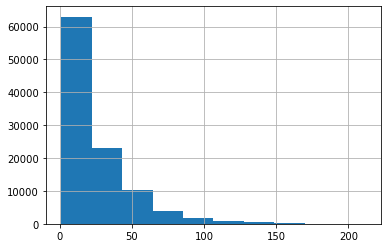

In [7]:
print(documents.shape)

documents.str.split().\
    map(lambda x: len(x)).\
    hist()

### Remove words that appear only once

In [8]:
####################### PENDING

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Tokenize words and Clean-up text

In [9]:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#3importpackages
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Compute bigrams & trigrams  

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents

In [10]:
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear min_count times or more).
def bi_tri_grams(documents, min_count):
    bigram = Phrases(documents, min_count=min_count)
    for idx in range(len(documents)):
        for token in bigram[documents[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                documents[idx].append(token)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Categorizing and tagging words

In [11]:
# function to remove accented characters
def tag_words(text):
    tags = nltk.pos_tag(text)
    nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return nouns

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Dictionary with the entire dataset

In [12]:
data_words = list(sent_to_words(documents))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# Create Dictionary
id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus_total = [id2word.doc2bow(text) for text in texts]

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Save document-term matrix

In [13]:
# save document-term matrix
savetxt(file_model + '_document_term_matrix.csv', corpus_total, delimiter=',', fmt='% s')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### Build LDA model

In [14]:
perplexity_score = []
coherence_score = []
indixes = []

index = 0
chunk_size = 250
documents_sample = documents[index:chunk_size-1]

time_start = time.time()

data_words = list(sent_to_words(documents_sample))
# Compute bigrams & trigrams
bi_tri_grams(data_words, 250)
# Categorizing and tagging words
data_words = list(map(tag_words, data_words))
# # Create Dictionary
# id2word = Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=corpus
                                       ,id2word=id2word
                                       ,num_topics=num_topics
                                       ,random_state=random_state
                                       ,chunksize=chunksize
                                       ,passes=50
                                       ,per_word_topics=True)

indixes.append(index)

# Evaluate LDA Model
# Compute Perplexity Score
perplexity = lda_model.log_perplexity(corpus)
perplexity_score.append(perplexity)

# Evaluate LDA Model
# Compute Coherence Score
coherence_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence = coherence_lda_model.get_coherence()
coherence_score.append(coherence)

# Save LDA Model
temp_file = datapath(file_model)
lda_model.save(temp_file)
temp_file = datapath(file_model + '_' + str(index).zfill(5))
lda_model.save(temp_file)

time_end = time.time()
hour, rem = divmod(time_end - time_start, 3600)
minute, second = divmod(rem, 60)
print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time elapsed - 00:00:38.06


### Incremental learning

In [15]:
documents_len = len(documents)

while index+(index+1)*chunk_size < documents_len:
    
    time_start = time.time()
    
    print(index, ' ----- ', (index+1)*chunk_size, ' ----- ', ((index+1)*chunk_size)+chunk_size-1)
    documents_sample = documents[(index+1)*chunk_size:((index+1)*chunk_size)+chunk_size-1]
    
    data_words = list(sent_to_words(documents_sample))
    # Compute bigrams & trigrams
    bi_tri_grams(data_words, 250)
    # Categorizing and tagging words
    data_words = list(map(tag_words, data_words))
    # Create Corpus
    texts = data_words
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    # Load LDA Model
    temp_file = datapath(file_model)
    lda_model = gensim.models.ldamodel.LdaModel.load(temp_file)
    # Update LDA Model
    lda_model.update(corpus)
    
    index = index + 1
    indixes.append(index)
    
    # Evaluate LDA Model
    # Compute Perplexity Score
    perplexity = lda_model.log_perplexity(corpus)
    perplexity_score.append(perplexity)

    # Evaluate LDA Model
    # Compute Coherence Score
    coherence_lda_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    coherence = coherence_lda_model.get_coherence()
    coherence_score.append(coherence)
    
    # Save LDA Model
    temp_file = datapath(file_model)
    lda_model.save(temp_file)
    temp_file = datapath(file_model + '_' + str(index).zfill(5))
    lda_model.save(temp_file)
    
    time_end = time.time()
    hour, rem = divmod(time_end - time_start, 3600)
    minute, second = divmod(rem, 60)
    print('time elapsed - {:0>2}:{:0>2}:{:05.2f}'.format(int(hour), int(minute), second))

0  -----  250  -----  499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


time elapsed - 00:00:36.39
1  -----  500  -----  749
time elapsed - 00:00:35.52
2  -----  750  -----  999
time elapsed - 00:00:38.31
3  -----  1000  -----  1249
time elapsed - 00:00:39.67
4  -----  1250  -----  1499
time elapsed - 00:00:38.99
5  -----  1500  -----  1749
time elapsed - 00:00:41.44
6  -----  1750  -----  1999
time elapsed - 00:00:41.67
7  -----  2000  -----  2249
time elapsed - 00:00:43.45
8  -----  2250  -----  2499
time elapsed - 00:00:43.34
9  -----  2500  -----  2749
time elapsed - 00:00:42.59
10  -----  2750  -----  2999
time elapsed - 00:00:43.48
11  -----  3000  -----  3249
time elapsed - 00:00:42.99
12  -----  3250  -----  3499
time elapsed - 00:00:43.75
13  -----  3500  -----  3749
time elapsed - 00:00:42.82
14  -----  3750  -----  3999
time elapsed - 00:00:42.80
15  -----  4000  -----  4249
time elapsed - 00:00:45.81
16  -----  4250  -----  4499
time elapsed - 00:00:43.13
17  -----  4500  -----  4749
time elapsed - 00:00:42.80
18  -----  4750  -----  4999
time 

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.71
21  -----  5500  -----  5749
time elapsed - 00:00:43.65
22  -----  5750  -----  5999
time elapsed - 00:00:42.32
23  -----  6000  -----  6249
time elapsed - 00:00:42.15
24  -----  6250  -----  6499
time elapsed - 00:00:42.80
25  -----  6500  -----  6749
time elapsed - 00:00:44.01
26  -----  6750  -----  6999
time elapsed - 00:00:44.59
27  -----  7000  -----  7249
time elapsed - 00:00:43.47
28  -----  7250  -----  7499
time elapsed - 00:00:42.58
29  -----  7500  -----  7749
time elapsed - 00:00:41.83
30  -----  7750  -----  7999
time elapsed - 00:00:42.51
31  -----  8000  -----  8249
time elapsed - 00:00:41.26
32  -----  8250  -----  8499
time elapsed - 00:00:42.35
33  -----  8500  -----  8749
time elapsed - 00:00:44.04
34  -----  8750  -----  8999
time elapsed - 00:00:43.12
35  -----  9000  -----  9249
time elapsed - 00:00:41.88
36  -----  9250  -----  9499
time elapsed - 00:00:42.18
37  -----  9500  -----  9749
time elapsed - 00:00:42.05
38  -----  9750  ----

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.65
119  -----  30000  -----  30249
time elapsed - 00:00:42.67
120  -----  30250  -----  30499
time elapsed - 00:00:42.90
121  -----  30500  -----  30749
time elapsed - 00:00:42.46
122  -----  30750  -----  30999
time elapsed - 00:00:42.99
123  -----  31000  -----  31249
time elapsed - 00:00:43.50
124  -----  31250  -----  31499
time elapsed - 00:00:43.08
125  -----  31500  -----  31749
time elapsed - 00:00:43.05
126  -----  31750  -----  31999
time elapsed - 00:00:43.99
127  -----  32000  -----  32249
time elapsed - 00:00:43.90
128  -----  32250  -----  32499
time elapsed - 00:00:43.84
129  -----  32500  -----  32749
time elapsed - 00:00:43.95
130  -----  32750  -----  32999
time elapsed - 00:00:44.35
131  -----  33000  -----  33249
time elapsed - 00:00:47.05
132  -----  33250  -----  33499
time elapsed - 00:00:43.83
133  -----  33500  -----  33749
time elapsed - 00:00:43.35
134  -----  33750  -----  33999
time elapsed - 00:00:43.83
135  -----  34000  -----  342

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.58
172  -----  43250  -----  43499
time elapsed - 00:00:41.65
173  -----  43500  -----  43749
time elapsed - 00:00:42.96
174  -----  43750  -----  43999
time elapsed - 00:00:42.69
175  -----  44000  -----  44249
time elapsed - 00:00:43.30
176  -----  44250  -----  44499
time elapsed - 00:00:42.55
177  -----  44500  -----  44749
time elapsed - 00:00:42.94
178  -----  44750  -----  44999
time elapsed - 00:00:42.50
179  -----  45000  -----  45249
time elapsed - 00:00:42.53
180  -----  45250  -----  45499
time elapsed - 00:00:43.10
181  -----  45500  -----  45749
time elapsed - 00:00:43.02
182  -----  45750  -----  45999
time elapsed - 00:00:43.08
183  -----  46000  -----  46249
time elapsed - 00:00:42.54
184  -----  46250  -----  46499
time elapsed - 00:00:41.05
185  -----  46500  -----  46749
time elapsed - 00:00:43.06
186  -----  46750  -----  46999
time elapsed - 00:00:44.41
187  -----  47000  -----  47249
time elapsed - 00:00:45.00
188  -----  47250  -----  474

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.23
192  -----  48250  -----  48499
time elapsed - 00:00:41.89
193  -----  48500  -----  48749
time elapsed - 00:00:42.68
194  -----  48750  -----  48999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.07
195  -----  49000  -----  49249
time elapsed - 00:00:42.94
196  -----  49250  -----  49499
time elapsed - 00:00:43.47
197  -----  49500  -----  49749
time elapsed - 00:00:43.33
198  -----  49750  -----  49999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.52
199  -----  50000  -----  50249
time elapsed - 00:00:44.12
200  -----  50250  -----  50499
time elapsed - 00:00:43.84
201  -----  50500  -----  50749
time elapsed - 00:00:44.46
202  -----  50750  -----  50999
time elapsed - 00:00:43.62
203  -----  51000  -----  51249
time elapsed - 00:00:43.89
204  -----  51250  -----  51499
time elapsed - 00:00:43.02
205  -----  51500  -----  51749
time elapsed - 00:00:42.15
206  -----  51750  -----  51999
time elapsed - 00:00:43.06
207  -----  52000  -----  52249
time elapsed - 00:00:42.60
208  -----  52250  -----  52499
time elapsed - 00:00:40.81
209  -----  52500  -----  52749
time elapsed - 00:00:42.12
210  -----  52750  -----  52999
time elapsed - 00:00:43.75
211  -----  53000  -----  53249
time elapsed - 00:00:42.74
212  -----  53250  -----  53499
time elapsed - 00:00:42.49
213  -----  53500  -----  53749
time elapsed - 00:00:42.51
214  -----  53750  -----  53999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.18
215  -----  54000  -----  54249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.67
216  -----  54250  -----  54499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:45.56
217  -----  54500  -----  54749
time elapsed - 00:00:43.37
218  -----  54750  -----  54999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.88
219  -----  55000  -----  55249
time elapsed - 00:00:43.38
220  -----  55250  -----  55499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.38
221  -----  55500  -----  55749
time elapsed - 00:00:42.38
222  -----  55750  -----  55999
time elapsed - 00:00:43.36
223  -----  56000  -----  56249
time elapsed - 00:00:41.74
224  -----  56250  -----  56499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.73
225  -----  56500  -----  56749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.04
226  -----  56750  -----  56999
time elapsed - 00:00:42.97
227  -----  57000  -----  57249
time elapsed - 00:00:44.26
228  -----  57250  -----  57499
time elapsed - 00:00:42.17
229  -----  57500  -----  57749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.59
230  -----  57750  -----  57999
time elapsed - 00:00:41.03
231  -----  58000  -----  58249
time elapsed - 00:00:42.67
232  -----  58250  -----  58499
time elapsed - 00:00:43.86
233  -----  58500  -----  58749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.17
234  -----  58750  -----  58999
time elapsed - 00:00:43.39
235  -----  59000  -----  59249
time elapsed - 00:00:42.86
236  -----  59250  -----  59499
time elapsed - 00:00:42.96
237  -----  59500  -----  59749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.58
238  -----  59750  -----  59999
time elapsed - 00:00:40.91
239  -----  60000  -----  60249
time elapsed - 00:00:42.61
240  -----  60250  -----  60499
time elapsed - 00:00:41.96
241  -----  60500  -----  60749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.51
242  -----  60750  -----  60999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.54
243  -----  61000  -----  61249
time elapsed - 00:00:43.90
244  -----  61250  -----  61499
time elapsed - 00:00:41.68
245  -----  61500  -----  61749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.02
246  -----  61750  -----  61999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.18
247  -----  62000  -----  62249
time elapsed - 00:00:42.36
248  -----  62250  -----  62499
time elapsed - 00:00:41.59
249  -----  62500  -----  62749
time elapsed - 00:00:42.90
250  -----  62750  -----  62999
time elapsed - 00:00:43.34
251  -----  63000  -----  63249
time elapsed - 00:00:42.68
252  -----  63250  -----  63499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.59
253  -----  63500  -----  63749
time elapsed - 00:00:41.59
254  -----  63750  -----  63999
time elapsed - 00:00:42.78
255  -----  64000  -----  64249
time elapsed - 00:00:43.68
256  -----  64250  -----  64499
time elapsed - 00:00:42.62
257  -----  64500  -----  64749
time elapsed - 00:00:42.56
258  -----  64750  -----  64999
time elapsed - 00:00:43.41
259  -----  65000  -----  65249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.09
260  -----  65250  -----  65499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.38
261  -----  65500  -----  65749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.32
262  -----  65750  -----  65999
time elapsed - 00:00:42.93
263  -----  66000  -----  66249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.19
264  -----  66250  -----  66499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.91
265  -----  66500  -----  66749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.76
266  -----  66750  -----  66999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.34
267  -----  67000  -----  67249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.24
268  -----  67250  -----  67499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.95
269  -----  67500  -----  67749
time elapsed - 00:00:42.94
270  -----  67750  -----  67999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.79
271  -----  68000  -----  68249
time elapsed - 00:00:41.41
272  -----  68250  -----  68499
time elapsed - 00:00:42.21
273  -----  68500  -----  68749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.61
274  -----  68750  -----  68999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.68
275  -----  69000  -----  69249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.97
276  -----  69250  -----  69499
time elapsed - 00:00:42.93
277  -----  69500  -----  69749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.66
278  -----  69750  -----  69999
time elapsed - 00:00:42.42
279  -----  70000  -----  70249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.09
280  -----  70250  -----  70499
time elapsed - 00:00:42.79
281  -----  70500  -----  70749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.96
282  -----  70750  -----  70999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.48
283  -----  71000  -----  71249
time elapsed - 00:00:43.39
284  -----  71250  -----  71499
time elapsed - 00:00:43.64
285  -----  71500  -----  71749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.68
286  -----  71750  -----  71999
time elapsed - 00:00:43.21
287  -----  72000  -----  72249
time elapsed - 00:00:42.84
288  -----  72250  -----  72499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.52
289  -----  72500  -----  72749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.76
290  -----  72750  -----  72999
time elapsed - 00:00:42.79
291  -----  73000  -----  73249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.41
292  -----  73250  -----  73499
time elapsed - 00:00:43.40
293  -----  73500  -----  73749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.45
294  -----  73750  -----  73999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.91
295  -----  74000  -----  74249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.55
296  -----  74250  -----  74499
time elapsed - 00:00:44.81
297  -----  74500  -----  74749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.62
298  -----  74750  -----  74999
time elapsed - 00:00:44.20
299  -----  75000  -----  75249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.62
300  -----  75250  -----  75499
time elapsed - 00:00:43.59
301  -----  75500  -----  75749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.69
302  -----  75750  -----  75999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.62
303  -----  76000  -----  76249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.61
304  -----  76250  -----  76499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.88
305  -----  76500  -----  76749
time elapsed - 00:00:42.85
306  -----  76750  -----  76999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.33
307  -----  77000  -----  77249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.97
308  -----  77250  -----  77499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.48
309  -----  77500  -----  77749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:40.45
310  -----  77750  -----  77999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.63
311  -----  78000  -----  78249
time elapsed - 00:00:42.20
312  -----  78250  -----  78499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.03
313  -----  78500  -----  78749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.68
314  -----  78750  -----  78999
time elapsed - 00:00:43.15
315  -----  79000  -----  79249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.53
316  -----  79250  -----  79499
time elapsed - 00:00:43.53
317  -----  79500  -----  79749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.23
318  -----  79750  -----  79999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.20
319  -----  80000  -----  80249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.69
320  -----  80250  -----  80499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.96
321  -----  80500  -----  80749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.10
322  -----  80750  -----  80999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.31
323  -----  81000  -----  81249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.60
324  -----  81250  -----  81499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.68
325  -----  81500  -----  81749
time elapsed - 00:00:44.43
326  -----  81750  -----  81999
time elapsed - 00:00:41.45
327  -----  82000  -----  82249
time elapsed - 00:00:41.80
328  -----  82250  -----  82499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.96
329  -----  82500  -----  82749
time elapsed - 00:00:42.13
330  -----  82750  -----  82999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.21
331  -----  83000  -----  83249
time elapsed - 00:00:42.82
332  -----  83250  -----  83499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.93
333  -----  83500  -----  83749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.14
334  -----  83750  -----  83999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.19
335  -----  84000  -----  84249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.47
336  -----  84250  -----  84499
time elapsed - 00:00:44.08
337  -----  84500  -----  84749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.36
338  -----  84750  -----  84999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.11
339  -----  85000  -----  85249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.85
340  -----  85250  -----  85499
time elapsed - 00:00:44.01
341  -----  85500  -----  85749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.73
342  -----  85750  -----  85999
time elapsed - 00:00:43.69
343  -----  86000  -----  86249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.44
344  -----  86250  -----  86499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.36
345  -----  86500  -----  86749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:01:06.32
346  -----  86750  -----  86999
time elapsed - 00:00:46.00
347  -----  87000  -----  87249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:40.27
348  -----  87250  -----  87499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:47.55
349  -----  87500  -----  87749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:40.67
350  -----  87750  -----  87999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:40.46
351  -----  88000  -----  88249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:39.22
352  -----  88250  -----  88499
time elapsed - 00:00:39.03
353  -----  88500  -----  88749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.29
354  -----  88750  -----  88999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:39.79
355  -----  89000  -----  89249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.15
356  -----  89250  -----  89499
time elapsed - 00:00:45.34
357  -----  89500  -----  89749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.51
358  -----  89750  -----  89999
time elapsed - 00:00:40.17
359  -----  90000  -----  90249
time elapsed - 00:00:40.44
360  -----  90250  -----  90499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:46.54
361  -----  90500  -----  90749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.96
362  -----  90750  -----  90999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.14
363  -----  91000  -----  91249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.73
364  -----  91250  -----  91499
time elapsed - 00:00:40.22
365  -----  91500  -----  91749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:40.91
366  -----  91750  -----  91999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:40.02
367  -----  92000  -----  92249
time elapsed - 00:00:41.58
368  -----  92250  -----  92499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.22
369  -----  92500  -----  92749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.61
370  -----  92750  -----  92999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:46.58
371  -----  93000  -----  93249
time elapsed - 00:00:50.75
372  -----  93250  -----  93499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:50.71
373  -----  93500  -----  93749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:50.45
374  -----  93750  -----  93999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:49.19
375  -----  94000  -----  94249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:49.51
376  -----  94250  -----  94499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:47.77
377  -----  94500  -----  94749
time elapsed - 00:00:44.99
378  -----  94750  -----  94999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:47.56
379  -----  95000  -----  95249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:45.72
380  -----  95250  -----  95499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:45.53
381  -----  95500  -----  95749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.02
382  -----  95750  -----  95999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.82
383  -----  96000  -----  96249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.56
384  -----  96250  -----  96499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.49
385  -----  96500  -----  96749
time elapsed - 00:00:45.27
386  -----  96750  -----  96999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.95
387  -----  97000  -----  97249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:45.08
388  -----  97250  -----  97499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:45.78
389  -----  97500  -----  97749
time elapsed - 00:00:45.04
390  -----  97750  -----  97999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:59.05
391  -----  98000  -----  98249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:54.99
392  -----  98250  -----  98499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:45.95
393  -----  98500  -----  98749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.05
394  -----  98750  -----  98999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.19
395  -----  99000  -----  99249
time elapsed - 00:00:43.27
396  -----  99250  -----  99499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.81
397  -----  99500  -----  99749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.95
398  -----  99750  -----  99999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:47.18
399  -----  100000  -----  100249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:51.55
400  -----  100250  -----  100499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:47.06
401  -----  100500  -----  100749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.14
402  -----  100750  -----  100999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.62
403  -----  101000  -----  101249
time elapsed - 00:00:42.57
404  -----  101250  -----  101499


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:42.80
405  -----  101500  -----  101749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:46.65
406  -----  101750  -----  101999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.69
407  -----  102000  -----  102249


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:41.39
408  -----  102250  -----  102499
time elapsed - 00:00:41.96
409  -----  102500  -----  102749


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:44.22
410  -----  102750  -----  102999


C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


time elapsed - 00:00:43.49


### Topics in LDA model

In [16]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.033*"hour" + 0.030*"goal" + 0.020*"check" + 0.020*"grace" + 0.016*"word" '
  '+ 0.016*"call" + 0.016*"fujifilm" + 0.016*"museum" + 0.013*"size" + '
  '0.010*"side"'),
 (1,
  '0.024*"book" + 0.021*"news" + 0.019*"event" + 0.019*"target" + 0.019*"farm" '
  '+ 0.014*"watch" + 0.012*"image" + 0.012*"porn" + 0.012*"salad" + '
  '0.012*"bacon"'),
 (2,
  '0.058*"street" + 0.026*"couture" + 0.026*"city" + 0.023*"wedding" + '
  '0.023*"store" + 0.023*"lady" + 0.019*"model" + 0.016*"men" + '
  '0.014*"perfection" + 0.013*"york"'),
 (3,
  '0.039*"style" + 0.033*"beauty" + 0.031*"fashion" + 0.031*"blogger" + '
  '0.031*"life" + 0.025*"travel" + 0.021*"summer" + 0.019*"time" + '
  '0.016*"love" + 0.015*"today"'),
 (4,
  '0.000*"photograph" + 0.000*"teraoka" + 0.000*"yuna" + 0.000*"jasmine" + '
  '0.000*"eddie" + 0.000*"fischer" + 0.000*"rare" + 0.000*"theo" + '
  '0.000*"jessi" + 0.000*"comb"'),
 (5,
  '0.035*"garden" + 0.031*"kid" + 0.031*"wardrobe" + 0.026*"milk" + '
  '0.026*"base" + 0

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot perplexity score progress along incremental learning iterations  

Lower the perplexity score represents a better model.  

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


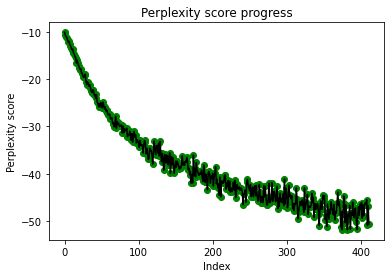

In [17]:
plt.title('Perplexity score progress')
plt.xlabel('Index')
plt.ylabel('Perplexity score')
plt.plot(indixes, perplexity_score, 'go', perplexity_score, 'k')
plt.show()

### Plot coherence score progress along incremental learning iterations  

Higher the coherence score represents a more human interpretable model.  

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


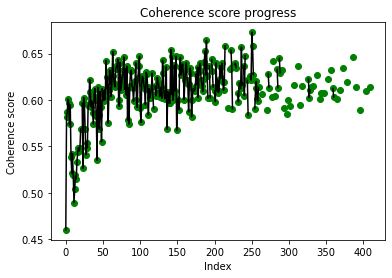

In [18]:
plt.title('Coherence score progress')
plt.xlabel('Index')
plt.ylabel('Coherence score')
plt.plot(indixes, coherence_score, 'go', coherence_score, 'k') 
plt.show()

### Visualize the topics-keywords

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.455281  0.012773       1        1  36.649716
1      0.003870  0.251300       2        1  10.571737
9     -0.001097 -0.290306       3        1   9.311609
2      0.017043 -0.196556       4        1   7.763074
0      0.072196  0.064578       5        1   7.664825
8      0.037708 -0.014971       6        1   7.569057
7      0.057484  0.059194       7        1   7.527611
6      0.039198  0.168962       8        1   6.600675
5      0.113505 -0.049976       9        1   5.775603
4      0.115375 -0.004998      10        1   0.566094, topic_info=             Term       Freq      Total Category  logprob  loglift
197         style  55.000000  55.000000  Default  30.0000  30.0000
129        beauty  47.000000  47.000000  Default  29.0000  29.0000
347        street  17.000000  17.000000  Default  28.0000  28.0000
190       fashion  43.000000  43.000000  Default  27.0000  27.0000
131       blogger  43.000000  43.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
55672       bovet   0.000394   0.975996  Topic10 -10.9288  -2.6417
55671      amadeo   0.000394   0.975996  Topic10 -10.9288  -2.6417
20937  tourbillon   0.000394   0.975996  Topic10 -10.9288  -2.6417
338          haha   0.000394   1.895093  Topic10 -10.9288  -3.3053
9299          ice   0.000394   2.841798  Topic10 -10.9288  -3.7105

[374 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
1981       5  1.020145  action
55671      7  1.024594  amadeo
626        7  1.026207  amazon
6608       8  1.008795    ange
7943       7  1.025959   anita
...      ...       ...     ...
529        8  1.008340  writer
66         1  1.007970    year
598        4  1.030328    york
4586       2  1.025607   yummy
14191      7  1.026446   zumba

[317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 10, 3, 1, 9, 8, 7, 6, 5])

### Save document-topic matrix (most significant topic per document)  
 https://github.com/Sim-Xuesi/content-based_movie_recommender/blob/master/Content%20Based%20Recommender%20System%20with%20LDA%20%26%20Cosine.ipynb  
 https://medium.com/@nicoleeesim97/building-a-simple-content-based-recommender-system-for-movies-and-tv-shows-73fec4f325ae  

In [20]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

doc_num, topic_num, prob = [], [], []

document_topic_matrix = documents

for n in range(len(documents)):
    get_document_topics = lda_model.get_document_topics(corpus_total[n], minimum_probability=0)
    doc_num.append(documents.index[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
    
data = {'Document': doc_num
        ,'Topic': topic_num
        ,'Probability': prob}
df = pd.DataFrame(data) 
df.to_csv(file_model + '_document_topic_matrix.csv', index=False)
print(df)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        Document  Topic  Probability
0        1797657      8     0.300168
1        2389775      8     0.549991
2        1762348      3     0.645359
3        2627997      3     0.718317
4        2005691      3     0.499609
...          ...    ...          ...
103346   2407448      3     0.764554
103347   1608998      9     0.820414
103348   2282108      3     0.686804
103349   1702303      3     0.419910
103350   2864876      1     0.366679

[103351 rows x 3 columns]


### Save document-topic matrix (all topic's probability per document)  
https://github.com/Sim-Xuesi/content-based_movie_recommender/blob/master/Content%20Based%20Recommender%20System%20with%20LDA%20%26%20Cosine.ipynb  
https://medium.com/@nicoleeesim97/building-a-simple-content-based-recommender-system-for-movies-and-tv-shows-73fec4f325ae  

In [21]:
doc_num = []
prob0, prob1, prob2, prob3, prob4, prob5, prob6, prob7, prob8, prob9 = ([] for i in range(num_topics))

document_topic_matrix = documents

for n in range(len(documents)):
    get_document_topics = lda_model.get_document_topics(corpus_total[n], minimum_probability=0)
    doc_num.append(documents.index[n])
    prob0.append(get_document_topics[0][1])
    prob1.append(get_document_topics[1][1])
    prob2.append(get_document_topics[2][1])
    prob3.append(get_document_topics[3][1])
    prob4.append(get_document_topics[4][1])
    prob5.append(get_document_topics[5][1])
    prob6.append(get_document_topics[6][1])
    prob7.append(get_document_topics[7][1])
    prob8.append(get_document_topics[8][1])
    prob9.append(get_document_topics[9][1])
    
data = {'Document': doc_num
        ,'Topic0': prob0
        ,'Topic1': prob1
        ,'Topic2': prob2
        ,'Topic3': prob3
        ,'Topic4': prob4
        ,'Topic5': prob5
        ,'Topic6': prob6
        ,'Topic7': prob7
        ,'Topic8': prob8
        ,'Topic9': prob9}

df = pd.DataFrame(data) 
df.to_csv(file_model + '_document_topic_matrix_full.csv', index=False)
print(df)

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


        Document    Topic0    Topic1    Topic2    Topic3    Topic4    Topic5  \
0        1797657  0.157154  0.014278  0.014278  0.299891  0.014279  0.014278   
1        2389775  0.050001  0.050001  0.050001  0.050001  0.050001  0.050001   
2        1762348  0.009088  0.009088  0.009088  0.645359  0.009088  0.100027   
3        2627997  0.031298  0.031298  0.031298  0.718318  0.031298  0.031298   
4        2005691  0.046850  0.061395  0.004263  0.499611  0.004263  0.047216   
...          ...       ...       ...       ...       ...       ...       ...   
103346   2407448  0.005953  0.005953  0.005953  0.764553  0.005954  0.005954   
103347   1608998  0.019953  0.019953  0.019957  0.019953  0.019954  0.019957   
103348   2282108  0.008028  0.008027  0.008027  0.686804  0.008027  0.088361   
103349   1702303  0.020000  0.020000  0.020000  0.419907  0.020000  0.220067   
103350   2864876  0.033336  0.366679  0.033336  0.033336  0.033336  0.033336   

          Topic6    Topic7    Topic8   

### Save topic-term matrix

In [22]:
# get topic-term-matrix
topic_term_matrix = lda_model.get_topics()
# save topic-term matrix
savetxt(file_model + '_topic_term_matrix.csv', topic_term_matrix, delimiter=',')

C:\Users\minio\anaconda3\envs\tfm-py-37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
